In [1]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests

In [7]:
from PIL import  ImageDraw, ImageFont
import matplotlib.pyplot as plt

In [2]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
image_path = "C:/Users/Harsh/Downloads/IMAGES - Copy/val/Super_resolution/hr/04862.JPEG"
image = Image.open(image_path)

In [5]:
inputs = processor(images=image, return_tensors="pt")

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the outputs to get the bounding boxes, labels, and scores
target_sizes = torch.tensor([image.size[::-1]])  # Target size as (height, width)
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

# Extract boxes, scores, and labels
boxes = results["boxes"].detach().numpy()  # Bounding boxes
scores = results["scores"].detach().numpy()  # Confidence scores
labels = results["labels"].detach().numpy()  # Class labels


In [13]:
confidence_threshold = 0.8
filtered_results = [(box, label, score) for box, label, score in zip(boxes, labels, scores) if score > confidence_threshold]

# Print detected objects and their details
if filtered_results:
    print("Detected Objects:")
    for i, (box, label, score) in enumerate(filtered_results):
        print(f"Object {i + 1}:")
        print(f"  - Label: {model.config.id2label[label]}")  # Convert label ID to human-readable label
        print(f"  - Confidence Score: {score:.2f}")
        print(f"  - Bounding Box: {box}")
else:
    print("No objects detected with high confidence.")


Detected Objects:
Object 1:
  - Label: dog
  - Confidence Score: 1.00
  - Bounding Box: [241.60669 280.3945  411.25482 815.80176]
Object 2:
  - Label: person
  - Confidence Score: 0.98
  - Bounding Box: [-4.1366577e-02  3.0471802e+00  1.1917596e+02  7.9335956e+02]
Object 3:
  - Label: chair
  - Confidence Score: 0.82
  - Bounding Box: [ 695.3177   362.58368 1022.915    840.5184 ]


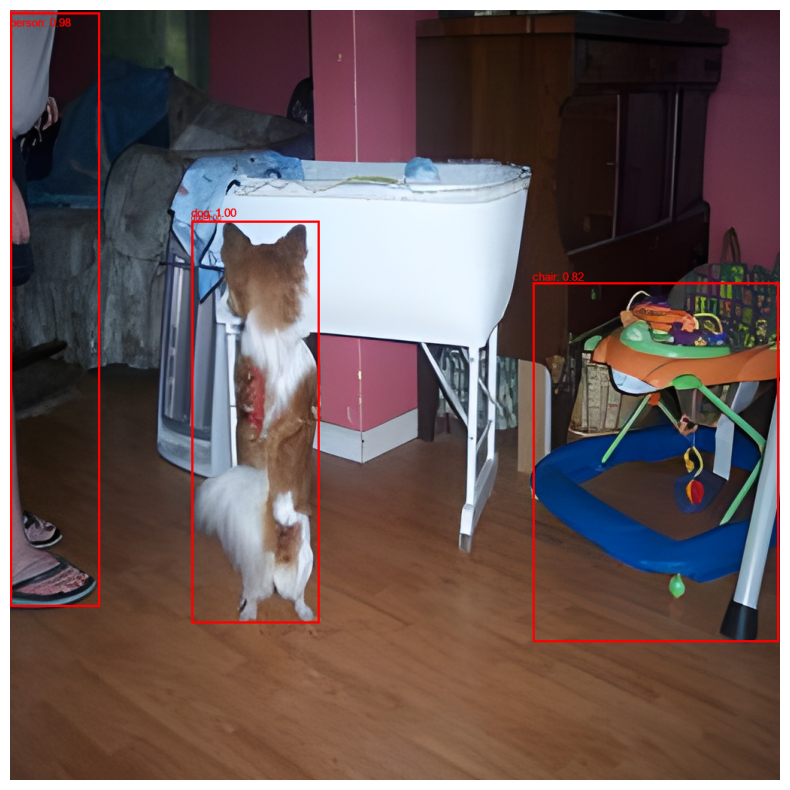

In [14]:
draw = ImageDraw.Draw(image)

# Load a font (fallback to default if unavailable)
try:
    font = ImageFont.truetype("arial.ttf", size=15)
except IOError:
    font = ImageFont.load_default()

for box, label, score in filtered_results:
    # Draw bounding box
    box = [int(b) for b in box]
    draw.rectangle(box, outline="red", width=3)
    
    # Add label and score
    label_text = f"{model.config.id2label[label]}: {score:.2f}"
    
    # Calculate text size using textbbox
    text_bbox = draw.textbbox((0, 0), label_text, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    
    # Set text position above the bounding box (or below if out of image bounds)
    text_position = (box[0], box[1] - text_height - 5 if box[1] - text_height - 5 > 0 else box[1] + 5)
    
    # Draw the text label
    draw.text(text_position, label_text, fill="red", font=font)

# Show the image with bounding boxes and labels
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

In [17]:
import tkinter as tk
from tkinter import filedialog, Label, messagebox
from PIL import Image, ImageTk, ImageDraw
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
import os
import sys

# Initialize DETR model and processor
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Function to load and display the image
def load_image(event=None):
    if load_image.clicked:  # Check if an image has already been uploaded
        return  # Disable further uploads
    
    # Open a file dialog to select an image
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.png *.jpeg")])
    
    if file_path:
        open_image(file_path)
        # Disable further clicks after the first upload
        load_image.clicked = True

# Function to open an image
def open_image(file_path):
    # Open the image file
    img = Image.open(file_path)
    
    # Get the original image size
    img_width, img_height = img.size
    
    # Desired display size (adjusted for border space)
    display_width = 580  # Leave 20px margin from 600px
    display_height = 580  # Leave 20px margin from 600px
    
    # Maintain aspect ratio
    aspect_ratio = min(display_width / img_width, display_height / img_height)
    new_size = (int(img_width * aspect_ratio), int(img_height * aspect_ratio))
    
    # Resize the image with the aspect ratio maintained
    img = img.resize(new_size, resample=Image.Resampling.BICUBIC)

    # Convert the image to Tkinter format and display it
    img_tk = ImageTk.PhotoImage(img)
    
    # Configure the image label to show the uploaded image
    image_label.config(image=img_tk, text="")  # Remove placeholder text
    image_label.image = img_tk  # Keep a reference to avoid garbage collection
    image_label.place(relx=0.5, rely=0.5, anchor="center")  # Center the image
    
    # Store the loaded image for saving and detection
    load_image.loaded_image = img
    detect_objects(file_path)  # Call object detection on the image

# Function to detect objects using DETR
def detect_objects(file_path):
    img = Image.open(file_path)
    inputs = processor(images=img, return_tensors="pt")
    
    # Run inference with DETR
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process the outputs
    target_sizes = torch.tensor([img.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]
    
    # Draw bounding boxes and labels on the image
    draw = ImageDraw.Draw(image)


    try:
       font = ImageFont.truetype("arial.ttf", size=15)
    except IOError:
       font = ImageFont.load_default()

    for box, label, score in filtered_results:
    # Draw bounding box
       box = [int(b) for b in box]
       draw.rectangle(box, outline="red", width=3)
     
    # Add label and score
    label_text = f"{model.config.id2label[label]}: {score:.2f}"
    
    # Calculate text size using textbbox
    text_bbox = draw.textbbox((0, 0), label_text, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    
    # Set text position above the bounding box (or below if out of image bounds)
    text_position = (box[0], box[1] - text_height - 5 if box[1] - text_height - 5 > 0 else box[1] + 5)
    
    # Draw the text label
    draw.text(text_position, label_text, fill="red", font=font)


    # Update the displayed image with bounding boxes
    img_tk = ImageTk.PhotoImage(img.resize((580, 580), resample=Image.Resampling.BICUBIC))
    image_label.config(image=img_tk)
    image_label.image = img_tk
    load_image.loaded_image = img

# Function to restart the application
def restart_app():
    os.execv(sys.executable, ['python'] + sys.argv)

# Function to create a new image (restart application)
def new_image():
    restart_app()  # Restart the application

# Function to save the image
def save_image():
    if load_image.loaded_image:
        file_path = "saved_image.png"  # Save to the same location with a default name
        load_image.loaded_image.save(file_path)
        messagebox.showinfo("Save Image", "Image saved successfully!")
    else:
        messagebox.showerror("Save Error", "No image to save!")

# Function to save the image as (Save As functionality)
def save_image_as():
    if load_image.loaded_image:
        file_path = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG files", ".png"), ("JPEG files", ".jpg")])
        if file_path:
            load_image.loaded_image.save(file_path)
            messagebox.showinfo("Save Image", "Image saved successfully!")
    else:
        messagebox.showerror("Save Error", "No image to save!")

# Initialize the load_image function's attributes
load_image.clicked = False
load_image.loaded_image = None  # To store the loaded image for saving

# Create the main application window
root = tk.Tk()
root.title("AI-Assisted Image Annotation Tool")
root.geometry("1000x600")  # Set window size

# Create a menu bar
menu_bar = tk.Menu(root)
root.config(menu=menu_bar)

# Create a "File" menu with options like New, Open, Save, Save As
file_menu = tk.Menu(menu_bar, tearoff=0)
menu_bar.add_cascade(label="File", menu=file_menu)

file_menu.add_command(label="New", command=new_image)
file_menu.add_command(label="Open", command=load_image)
file_menu.add_command(label="Save", command=save_image)
file_menu.add_command(label="Save As", command=save_image_as)
file_menu.add_separator()
file_menu.add_command(label="Exit", command=root.quit)

# Create frames for left, center, and right panels
left_panel = tk.Frame(root, width=200, bg="lightgray")  # Manual editing panel
left_panel.pack(side="left", fill="y")

center_panel = tk.Frame(root, width=600, bg="white")  # Image display panel
center_panel.pack(side="left", fill="both", expand=True)

right_panel = tk.Frame(root, width=200, bg="lightgray")  # AI and LLM-based editing panel
right_panel.pack(side="right", fill="y")

# Add a label to display the image in the center panel with initial text and padding
image_label = Label(center_panel, text="Click to upload an image", bg="white", fg="gray", font=("Helvetica", 20))
image_label.pack(expand=True)

# Bind the left mouse button click event to the load_image function for the entire center panel
center_panel.bind("<Button-1>", load_image)

# Add placeholder buttons for future manual editing functionalities in the left panel
manual_label = tk.Label(left_panel, text="Manual Editing", bg="lightgray")
manual_label.pack(pady=10)

manual_button1 = tk.Button(left_panel, text="Adjust Bounding Box")
manual_button1.pack(pady=5)

manual_button2 = tk.Button(left_panel, text="Crop Image")
manual_button2.pack(pady=5)

# Add a placeholder for the right panel (LLM-based editing options)
llm_label = tk.Label(right_panel, text="AI-Assisted Editing", bg="lightgray")
llm_label.pack(pady=10)

llm_button1 = tk.Button(right_panel, text="Resize Box using AI")
llm_button1.pack(pady=5)

llm_button2 = tk.Button(right_panel, text="Auto Label using AI")
llm_button2.pack(pady=5)

# Add a textbox for LLM-based commands
llm_textbox = tk.Text(right_panel, height=5, width=25)
llm_textbox.pack(pady=10)

# Run the Tkinter event loop
root.mainloop()


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: name 'img' is not defined